In [15]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from datetime import date
import time
import calendar
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd

current_date_and_time = time.time() #get the current epoch time

LastDate = int(current_date_and_time) #change the current date into integer format so as to fit into CSV link below

now = datetime.now() #get today's date

last2year = now + relativedelta(years=-2) #get the date 2 years ago from today

last2year_string = last2year.strftime("%a %b %d %H:%M:%S %Y")

StartDate = int(calendar.timegm(time.strptime(last2year_string))) #get the epoch time for the date 2 years ago and convert it to integer

Tickers = ['TSCO.L', 'SBRY.L', '3382.T', 'CA.PA', 'AXFO.ST', 'KR', 'WMT'] #ticker list

dataset = {} #create a dictionary object for containing the stock price for every ticker

#iterate each ticker in the ticker list
for Ticker in Tickers:
        #read the csv file dynamically for every ticker
	df = pd.read_csv(f'https://query1.finance.yahoo.com/v7/finance/download/{Ticker}?period1={StartDate}&period2={LastDate}&interval=1d&events=history&includeAdjustedClose=true')
	df['Ticker'] = Ticker
	dataset[Ticker] = df
	#time.sleep(1)

StockPrice = pd.concat(dataset) #put stock prices of all tickers together in one table 
StockPrice = StockPrice.reset_index(drop = True) #reset the index
StockPrice = StockPrice.set_index('Ticker')

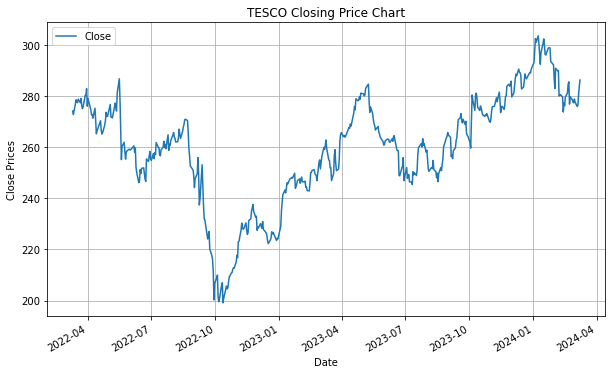

In [16]:
#plot close price in a line chart for Tesco stock
df_close = StockPrice.loc['TSCO.L', ['Date', 'Close']]
df_close.reset_index(drop=True, inplace=True)
df_close['Date'] = pd.to_datetime(df_close['Date'], format='%Y-%m-%d') #convert dates to datetime objects
df_close.plot('Date', 'Close', figsize=(10,6))
df_close = df_close.set_index("Date")
df_close.dropna(inplace = True)

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('TESCO Closing Price Chart')
plt.show()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

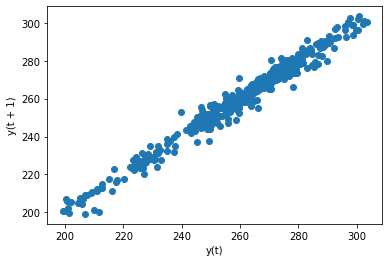

In [17]:
# The lagplot shows the price data is not random but likely autocorrelation with a clear straight line along the diagonal
pd.plotting.lag_plot(df_close, lag=1)

In [18]:
#A function testing for stationarity
def test_stationarity(timeseries):
    #Determing rolling mean and rolling standard deviation
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics
    plt.plot(timeseries.Close, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    # carry out dickey fuller test by checking if the p-value is smaller than the alpha (i.e. 0.05)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries.Close,autolag='AIC')
    #printing the results of dickey fuller test
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

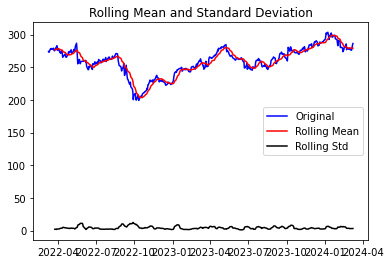

Results of dickey fuller test
Test Statistics                 -1.573290
p-value                          0.496996
No. of lags used                 4.000000
Number of observations used    498.000000
critical value (1%)             -3.443549
critical value (5%)             -2.867361
critical value (10%)            -2.569870
dtype: float64


In [19]:
#call the test_stationarity function on the original data
# the p-value > alpha, so the original data set is non-stationary which lead us to have a differencing as below
test_stationarity(df_close.dropna())

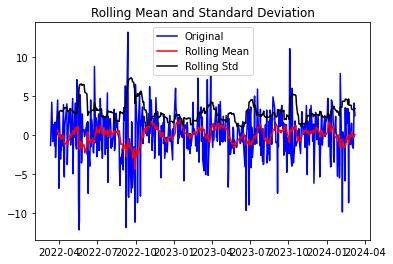

Results of dickey fuller test
Test Statistics               -1.059715e+01
p-value                        6.306686e-19
No. of lags used               3.000000e+00
Number of observations used    4.980000e+02
critical value (1%)           -3.443549e+00
critical value (5%)           -2.867361e+00
critical value (10%)          -2.569870e+00
dtype: float64


In [20]:
# check the stationarity of the first-differenced data set
test_stationarity(df_close.diff().dropna()) # d = 1 in ARIMA model, as the resulted p is less than alpha of 0.05

<Figure size 432x288 with 0 Axes>

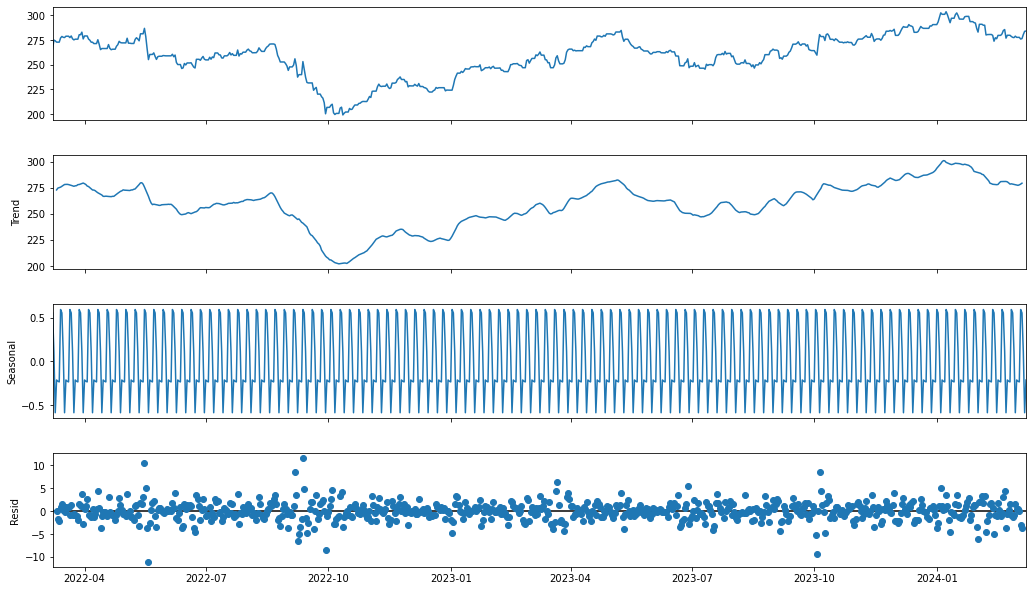

In [17]:
#To separate the trend and the seasonality from a time series
#It does not have growing trend and no obvious seasonality
df_close2 = df_close.asfreq('D', method = 'pad') #set the date index as the frequency, and any nill values to be replaced by last valid observation  
result = seasonal_decompose(df_close2)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

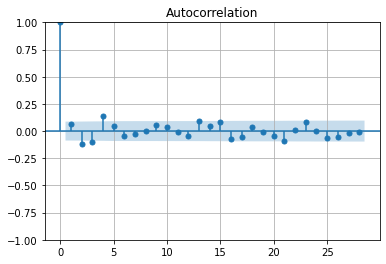

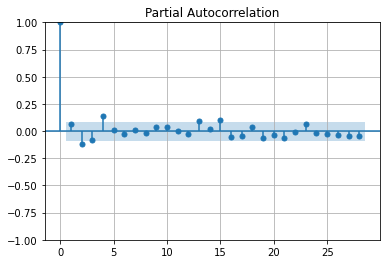

In [18]:
# plot the acf and pacf graph of the first-differenced time series for checking p (i.e. lag order) of the ARIMA function
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(df_close.diff().dropna(), alpha = 0.05)
plt.grid(True) 
plot_pacf(df_close.diff().dropna(), alpha = 0.05)
plt.grid(True) #from pacf, there is a spike at lag order 2, which shows p parameter probably = 2 and can be further checked in auto_arima function below

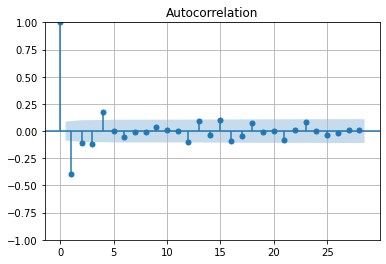

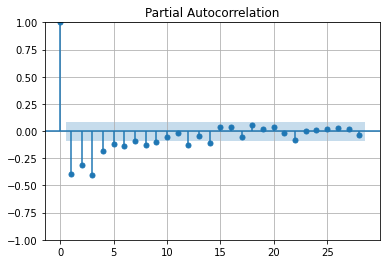

In [19]:
#As the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced, so we stick with d = 1 and p = 2 from above
plot_acf(df_close.diff().diff().dropna(), alpha = 0.05)
plt.grid(True) 
plot_pacf(df_close.diff().diff().dropna(), alpha = 0.05)
plt.grid(True) 

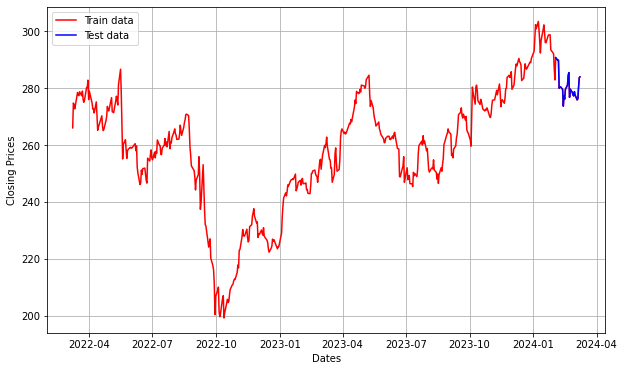

In [20]:
#split data into train and training set
train_data, test_data = df_close.iloc[0:int(len(df_close)*0.95)], df_close.iloc[int(len(df_close)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'red', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  479
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1224.160
Date:                Fri, 08 Mar 2024   AIC                           2458.320
Time:                        21:15:35   BIC                           2479.168
Sample:                             0   HQIC                          2466.516
                                - 479                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3160      0.095      3.314      0.001       0.129       0.503
ar.L2         -0.7902      0.106     -7.457      0.000      -0.998      -0.582
ma.L1         -0.2554      0.114     -2.242      0.0

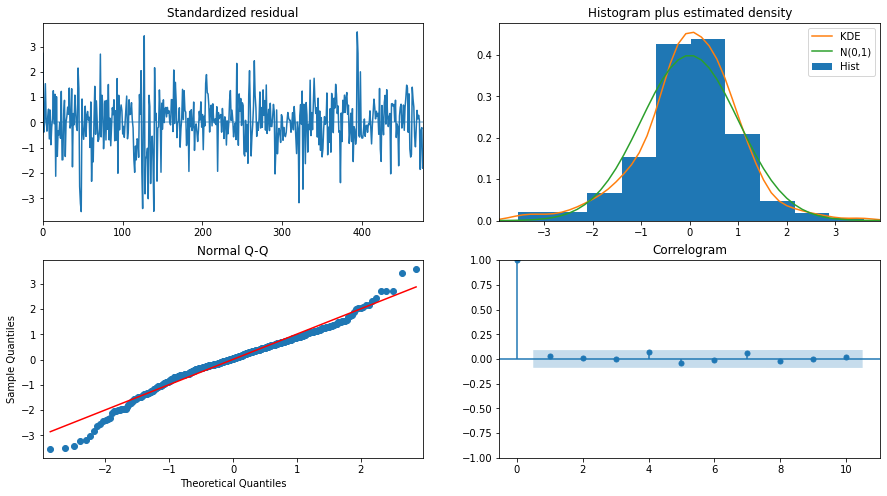

In [21]:
#run auto_arima function to find the p and q parameters
#the optimal results of (p, d, q) = (2, 1, 2) are in line with our above observations
model_autoARIMA = auto_arima(train_data, error_action='ignore', seasonal=False, d=1)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [22]:
#Modeling
fitted = sm.tsa.SARIMAX(train_data.dropna(), order=(2, 1, 2)).fit()

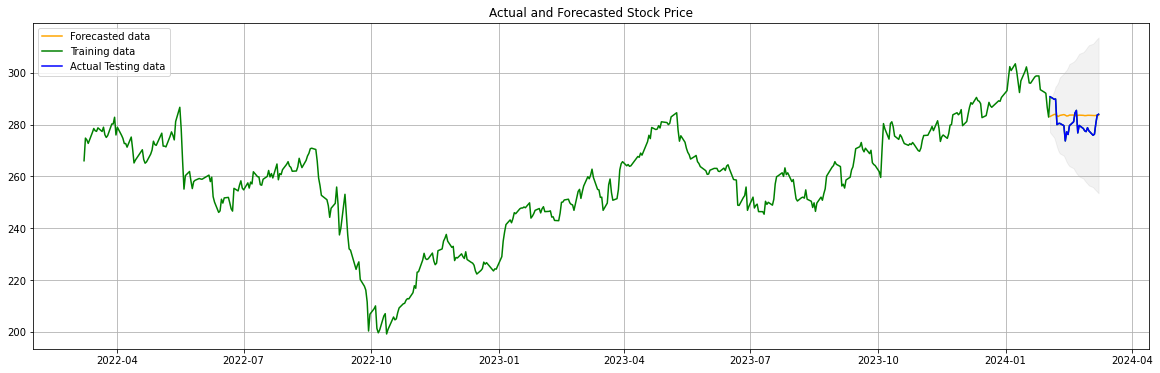

In [30]:
start_index = int(len(df_close)*0.95) #starting index of the test_data
end_index = start_index + len(test_data) - 1 #ending index of the test_data

fc = fitted.predict(start = start_index, end = end_index, alpha = 0.05) #find the predicted values for the period of test_data using the optimal ARIMA model 
forecast = pd.DataFrame(fc)
forecast['Date'] = test_data.index #add the dates of test_data to the forecasted data
forecast = forecast.set_index("Date")

#get the 95% confidence interval of the predicted values
fc_interval = fitted.get_prediction(start = start_index, end = end_index)
forecast_int = fc_interval.conf_int(alpha = 0.05)
forecast_int['Date'] = test_data.index #add the dates of test_data to the forecasted data
forecast_int = forecast_int.set_index("Date") 

plt.figure(figsize=(20,6))
plt.plot(forecast, 'orange', label='Forecasted data')
plt.plot(df_close, 'green', label='Training data')
plt.plot(test_data, 'blue', label='Actual Testing data')
#extract the the lower bound and upper bound of the confidence interval of the predicted values and fill the range in grey
plt.fill_between(forecast_int.index, forecast_int['lower Close'], forecast_int['upper Close'], color='k', alpha=.05)
plt.legend(loc='upper left')
plt.grid(True)
plt.title('Actual and Forecasted Stock Price')
plt.show()

In [24]:
#find the root mean square error (rmse) and mean absolute percentage error (mape)
#With a MAPE of around 1.7%, the model is 98.3% accurate in its prediction
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast['predicted_mean'] - test_data['Close'])/np.abs(test_data['Close']))
print('MAPE: '+str(mape))

RMSE: 5.30435961808846
MAPE: 0.016938142152491384
